# A collection of examples showing how to carry out computations of PL  IFP  

## for multiple MD trajectories, including   trajectories obtained from  RAMD simualtions




### Application example: Example:  muscarinic receptor M2 bound to iperoxo. 

    1. Computation of PL IFPs for a single dcd trajectory
    2. Computation  of IFP for a set of trajectories using a trajectory object :
        - Computation of PL IFPs for all equilibration trajectories
        - Computation of PL IFPs for all dissociation trajectories 
    here dcd trajectories are used as an example, but other formats (xtc, nc) can be used as well

    
    
 
### Input data required:
    MD trajectory file of a complex
    pdb file of a complex (for example, generated from the first frame)
    pdb and mol2 file of a ligand separately 
    Data can be downloaded from https://zenodo.org/record/3981155#.XzQEUCgzaUk
    
    Specifically, you will need 
    NAMD_eq.tar.gz
 

    Data directory must look like this (otherwise you have to edit file location in the code)
    
    Data
    ├── 4MQT
    │   ├── IXO.pdb
    │   └── moe.mol2
    │   ├── AMBER_eq                     # from AMBER_eq.tar.gz
    │   │   └── ORTO-CHL-prod8-NPT.pdb
    │   ├── NAMD                         # from NAMD_eq.tar.gz
    │   │   ├── Replica1
    │   │   │   └── ORT-CHL_repl.dcd
    │   ├── RAMD                         # from RAMD.tar.gz
    │   │   ├── Replica1
    │   │   │   ├── Traj1
    │   │   │   │   └── ORTO-CHL_108_ramd_016.dcd
    │   │   │   └── Traj2
    │   │   │       └── ORTO-CHL_104_ramd_016.dcd
    │   │   └── Replica2
    │   │   │   ├── Traj1
    │   │   │   │   └── ORTO-CHL_111_ramd_016.dcd
    │   │   │   └── Traj2
    │   │   │       └── ORTO-CHL_105_ramd_016.dcd
   

       
### Packages required:
    numpy
    matplotlib
    MDAnalysis Version: 0.20.1
    pandas
    seaborn
    RDkit
    nglview
    code is written on Python 3.x and tested on the version 3.7



### v 1.0
    06.06.2020
    Copyright (c) 2020
    Released under the EUPL Licence, v1.2 or any higher version
    
### Authors: Daria Kokh & Fabian Ormersbach 
    Daria.Kokh@h-its.org
    Heidelberg Institute of Theoretical Studies (HITS, www.h-its.org)
    Schloss-Wolfsbrunnenweg 35
    69118 Heidelberg, Germany
    

In [ ]:
import os, sys
import builtins
import MDAnalysis as mda

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

import nglview as nv

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from Scripts.IFP_generation import *
from Scripts.Trajectories import *

builtins.SHOULD_SHOW_PLOTS = True


RDKit WARNING: [17:20:11] Enabling RDKit 2019.09.3 jupyter extensions


_ColormakerRegistry()

##  1. Computation of PL IFPs  for a single dcd trajectory

    Generation of PL IFP  for a membrane protein bound to a ligand (muscarinic receptor M2; PDB:4MQT)
    
    Data used:
    PDB file of a complete system equilibrated using AMBER
    MD trajectory in DCD format (generated using NAMD software)
    ligand PDB and Mol2 files 
    (Important: not all Mol2 formats can be read by RDKit, file generated by MOE software works well)
    
    Result:
    A dataframe (df_prop_complet) will be generated; it contains PL IFP for each frame analyzed


### 1.1 Data preparation and loading a MD trajectory

In [2]:
# Define the path to our input data
ref =  "Data/4MQT/AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
traj = "Data/4MQT/RAMD/Replica1/Traj1/ORTO-CHL_108_ramd_016.dcd"
ligand_pdb = "Data/4MQT/IXO.pdb"
ligand_mol2 = "Data/4MQT/moe.mol2"

# Define the part of the trajectory we will analize
start = 200
stop = -1
step = 10

# Load the trajectory into an MDAnalysis universe
u = mda.Universe(ref,traj)
print("the total length of trajectory: ",len(u.trajectory)," frames")

# Define the identifier of the ligand we want to analize
sel_ligands = "IXO"

# Define a sub-system we wish to analize (we are going to exclude membrane residues now for faster compution)
u_reduced = u.select_atoms(" protein or (resname WAT SOL HOH "+sel_ligands+")")

# Load part of the trajectory into memory
u_mem = mda.Merge(u_reduced).load_new(AnalysisFromFunction(
                    lambda ag: ag.positions.copy(), u_reduced).run(
                        start=start,stop=stop,step=step).results,format=MemoryReader)
print('Will be analized: ', len(u_mem.trajectory), 'frames')

the total length of trajectory:  721  frames
Will be analized:  52 frames


### 1.2  Generation of ligand properties 

        For this functions of the Ligand class is used. They are mainly based on the RDKit library to detect standard physical/chemical properties of the ligand functional groups and atoms.
    Details about the definition of the RDKit properties can be found at https://github.com/rdkit/rdkit/blob/master/Data/BaseFeatures.fdef. 

    Additionally, hydrophobic properties of F atoms and ionazable H-acceptor properties of PO3 groups (which are not included in th RDKit) will be added.


Atoms found in the MOL2 file:  ['C01', 'N02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'O09', 'C10', 'N11', 'O12', 'C13', 'C14', 'H011', 'H012', 'H013', 'H031', 'H032', 'H033', 'H041', 'H042', 'H043', 'H051', 'H052', 'H081', 'H082', 'H131', 'H132', 'H141', 'H142']
...............Ligand properties:................
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
............Important! ........
The following residue names will be used to identify ligand in the PDB file:  ['IXO']
Ligand properties:  {'Acceptor': ['O09', 'O12'], 'PosIonizable': ['N02'], 'Hydrophobe': ['C14', 'C06', 'C07']}


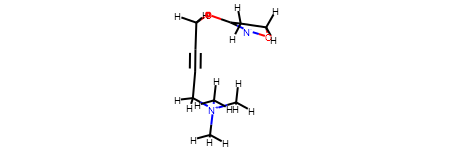

In [3]:
my_ligand = Ligand("./",ligand_pdb,ligand_mol2)
properties = my_ligand.property_list
print("Ligand properties: ",properties)
my_ligand.mol



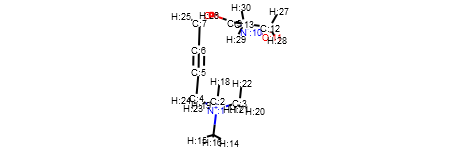

In [4]:
#  another representation
def mol_with_atom_index(mol):
    for atom in mol.GetAtoms():
        atom.SetAtomMapNum(atom.GetIdx())
    return mol
mol_with_atom_index(my_ligand.mol)

### 1.3 Generation of  PL IFPs  for a single trajectory (this may take about 5-10 min)

    additionally will be  reported:

    (i) the number of water molecules in the ligand solvation shell
    (ii) all residues around the ligand within 4A (RE=True)


In [5]:
# Compute the IFP
df_prop,df_HB,df_WB = IFP(u_mem, sel_ligands, properties, WB_analysis=True, RE=True, Lipids= [])

# Merge the data into one dataframe
df_prop_complete = table_combine(df_HB, df_WB, df_prop, sel_ligands)

# Plot the finished table (left plot - IFPs, middle plot- PL contacts (RE), right plot - number of water molecules in the water shell)

print(" List of all computed IFPs and unspecific contacts PR(RE_*):\n",df_prop_complete.columns.values)


Start HB analysis 17:20:17.049509
Start WB analysis 17:20:30.275908
Start collecting IFPs:  17:21:47.340639
Start building IFP table:  17:26:51.794736
IFP database is ready  17:26:51.874667
 List of all computed IFPs and unspecific contacts PR(RE_*):
 ['time' 'AR_TYR62' 'HY_TYR62' 'RE_TYR62' 'AR_TYR65' 'RE_TYR65' 'RE_TRP71'
 'AR_TRP81' 'HY_TRP81' 'RE_TRP81' 'HY_LEU82' 'RE_LEU82' 'IP_ASP85'
 'RE_ASP85' 'AR_TYR86' 'HY_TYR86' 'RE_TYR86' 'RE_SER89' 'WB_SER89'
 'HY_ASN90' 'RE_ASN90' 'HY_VAL93' 'RE_VAL93' 'HD_TRP137' 'HY_TRP137'
 'RE_TRP137' 'RE_CYX158' 'RE_TYR159' 'HY_ALA176' 'RE_ALA176' 'RE_PHE177'
 'RE_PHE232' 'HY_TRP236' 'RE_TRP236' 'AR_TYR239' 'HY_TYR239' 'RE_TYR239'
 'WB_TYR239' 'HD_ASN240' 'RE_ASN240' 'WB_ASN240' 'HY_TYR262' 'AR_TYR262'
 'HD_TYR262' 'RE_TYR262' 'RE_TRP263' 'RE_LEU264' 'HY_CYS265' 'HD_CYS265'
 'RE_CYS265' 'HY_TYR266' 'RE_TYR266' 'WAT']


### 1.4 Visualization of detected IFPs

    The first plot shows the devlopment of detected IFPs over the time of the trajetorie.  
    The second plot shows all contacts between ligand and protein over the time of the trajectorie.  
    The third plot shows the number of water molecules in a water shell of the ligand.

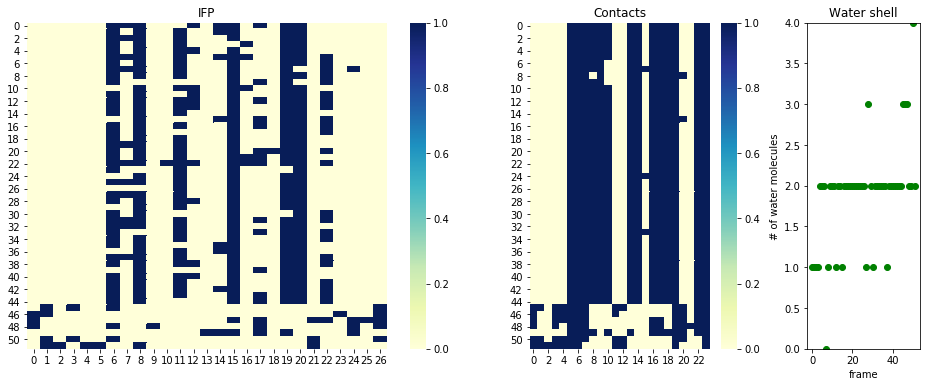

In [6]:
Plot_IFP(df_prop_complete)

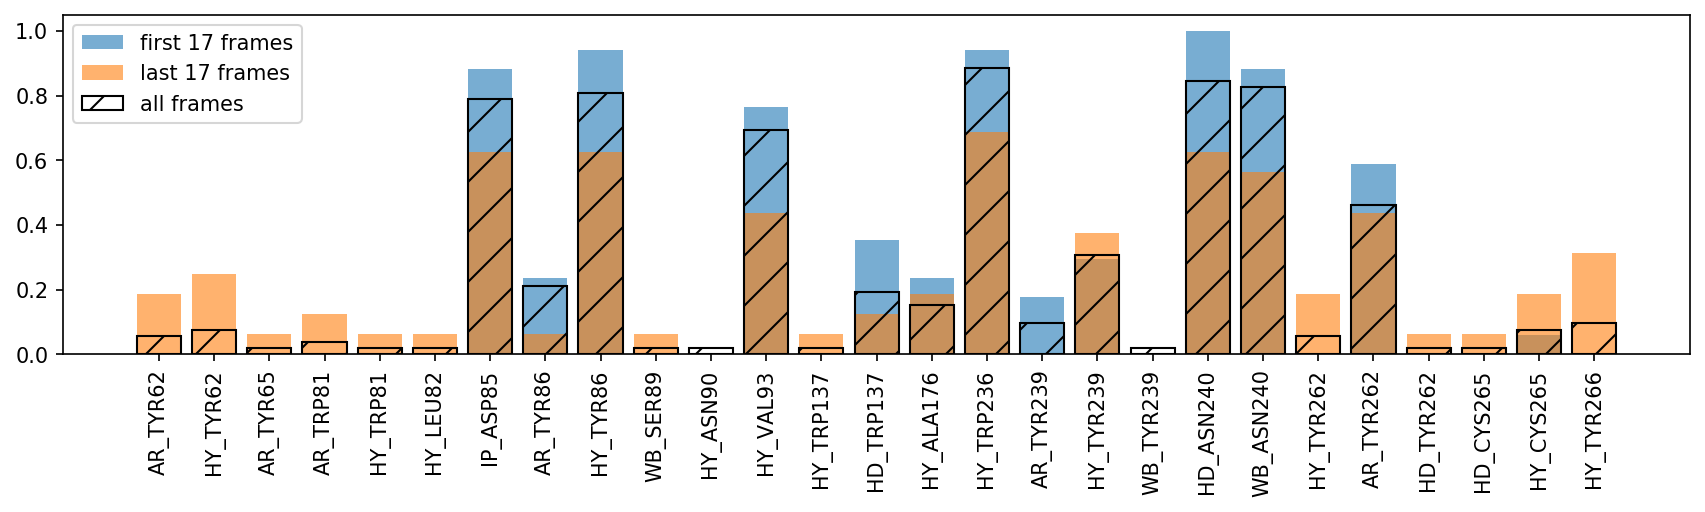

In [7]:
# Alternative way to plot detected IFPs: average IFPs value are shown for the first and last parts of the trajectory and for a whole trajectory
Plot_IF_trajectory(df_prop_complete,head_tail=-1)

## 2. Computation  of IFP using a trajectory object

In addition to the functions presented in 1.2 , we offer the option of performing all of the above in the scope of the trajectories class.  
Note that we start analyzing only after the last 200/300 frames and the ligand is moving out of the binding pocket, which is the reason for the large RMSD.

### 2.1 Instantiate a trajectory object

#### first we have to build an object that will contain all trajectories found by using a given pathway

In [8]:
# Define the path to the stored data
DIR_all = "Data/4MQT/"
DIR_ramd = "RAMD/Replica*"
DIR_namd = "NAMD_eq/Replica1*"
ref_pdb =  "AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
ligand_pdb = "IXO.pdb"
ligand_mol2 = "moe.mol2"

# Instantiate the trajectorie object with the paths/ filenames for the data
tr = trajectories(DIR_all,namd_tmpl= DIR_namd, ramd_tmpl= DIR_ramd, ligand_pdb=ligand_pdb,
                  ligand_mol2=ligand_mol2,ramd_traj_tmpl = "Traj*/*dcd",pdb = ref_pdb, timestep = 1)

Atoms found in the MOL2 file:  ['C01', 'N02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'O09', 'C10', 'N11', 'O12', 'C13', 'C14', 'H011', 'H012', 'H013', 'H031', 'H032', 'H033', 'H041', 'H042', 'H043', 'H051', 'H052', 'H081', 'H082', 'H131', 'H132', 'H141', 'H142']
...............Ligand properties:................
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
............Important! ........
The following residue names will be used to identify ligand in the PDB file:  ['IXO']
Ligand atoms found in the trajectory  IXO
ligand name:       IXO
Equilibration trajectories will be searched using the template:  Data/4MQT//NAMD_eq/Replica1*/*dcd
1  Equilibration trajectories found
Dissociation trajectories will be searched using the template:  Data/4MQT//RAMD/Replica*/Traj*/*dcd
2  RAMD traj. found in  Data/4MQT//RAMD\Replica1
2  RAMD traj. found in  Data/4MQT//RAMD\Replica2


### 2.2 Computation of PL IFPs for all equilibration trajectories (takes about 15 min)

#### i. Since there are no water bridges in the present structure (see results of the section 1.2) we can speed up simulations by excludion water completely. For this we will re-define the variable sub_system of the trajectory object.
#### ii. IFPs for the last MD 300 frames  with the stride of 3 will be simulated
#### iii. the following additional properties will be computed:

    (i) all residues around the ligand within 4A (RE=True)
    (ii) the number of ligand contacts with specific residues, in this case - two kinds of the lipid residues (Lipids= ["CHL", "PA"])
    (iii) RMSD of four protein framents (see auxi_selection)

For the following diagram line 0-3 represent RMSD addition selections provided by auxi_selection list. 



>>>>>>>>>>>>>>>>> Replica:  Data/4MQT//NAMD_eq\Replica1\ORT-CHL_repl.dcd 

total number of frames= 1418; file size 1934 M
>>>sub-system selected  (resname IXO) or  protein or (resname MG MN CA Mg Mn) or (resname WAT HOH SOL TIP3) or ( resname  CHL PA PC )  or ((resid 8:21) and (not type H)) or ((resid 48:65) and (not type H)) or ((resid 88:91) and (not type H)) or ((resid 151:157) and (not type H))
will be analyzed  100 frames
traj# 0 RMSD protein:  1.8287229167903019 RMSD ligand:  1.2617531093250236 ligand residue name IXO
Start HB analysis 17:30:49.655027
Start WB analysis 17:31:06.703212
Start collecting IFPs:  17:32:51.422046
Start building IFP table:  17:46:40.435769
IFP database is ready  17:46:40.602670


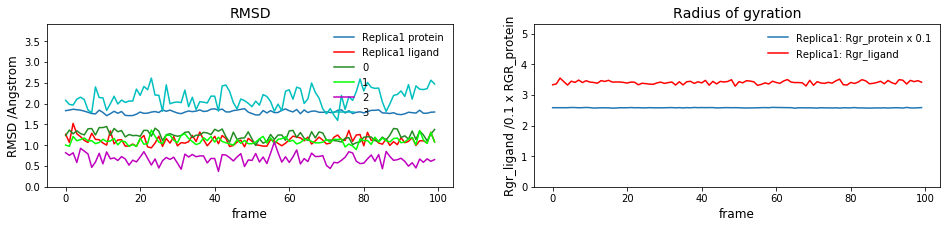

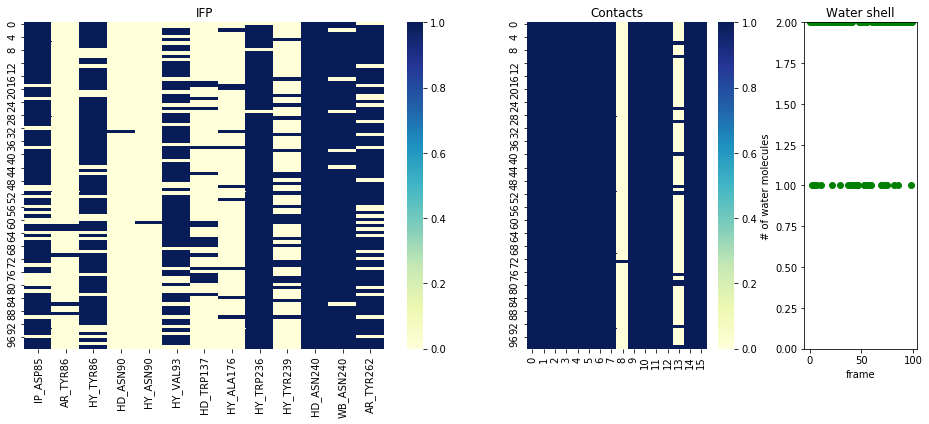

#  Replica: 0 Replica1


In [9]:
# name of the output file with IFP dataset 
out_name = 'ORTO-CHL-lipid14'

# here we define residues to be used to compute RMSD
auxi_selection = ["((resid 8:21) and (not type H))","((resid 48:65) and (not type H))","((resid 88:91) and (not type H))","((resid 151:157) and (not type H))"]

# re-define part of the system to use in computations; ligand and the list of Lipids will be added automatically
#tr.sub_system = " protein "

end = -300 
step =3 
# We start the analysis of the namd data and define ...
tr.analysis_all_namd(WB_analysis = True, Lipids = ["CHL", "PA", "PC"],auxi_selection = auxi_selection,step_analysis=step, start_analysis=end)

# Save and visualize the IFP dataframe to the specified location
# In the RMSD plot, in addition to the protein and ligand (heavy atoms) RMSD, also RMSD of the protein fragments given as an input (auxi_selection) are shown
IFP_table = tr.namd.IFP_save(tr.PRJ_DIR+out_name+"_NAMD_com.pkl")



In the RMSD plot above RMSD relative to the reference structure (ref_pdb =  "AMBER_eq/ORTO-CHL-prod8-NPT.pdb") is plotted 
- for the protein heavy atoms
- for ligand heavy atoms
- for each element in the selection array auxi_selection., i.e 
["((resid 8:21) and (not type H))",
"((resid 48:65) and (not type H))",
"((resid 88:91) and (not type H))",
"((resid 151:157) and (not type H))"]
are denoted in the plot by the numbers 0-3, respectively

An alternative plot of detected IFPs in the first and last parts of the trajectory and on average .

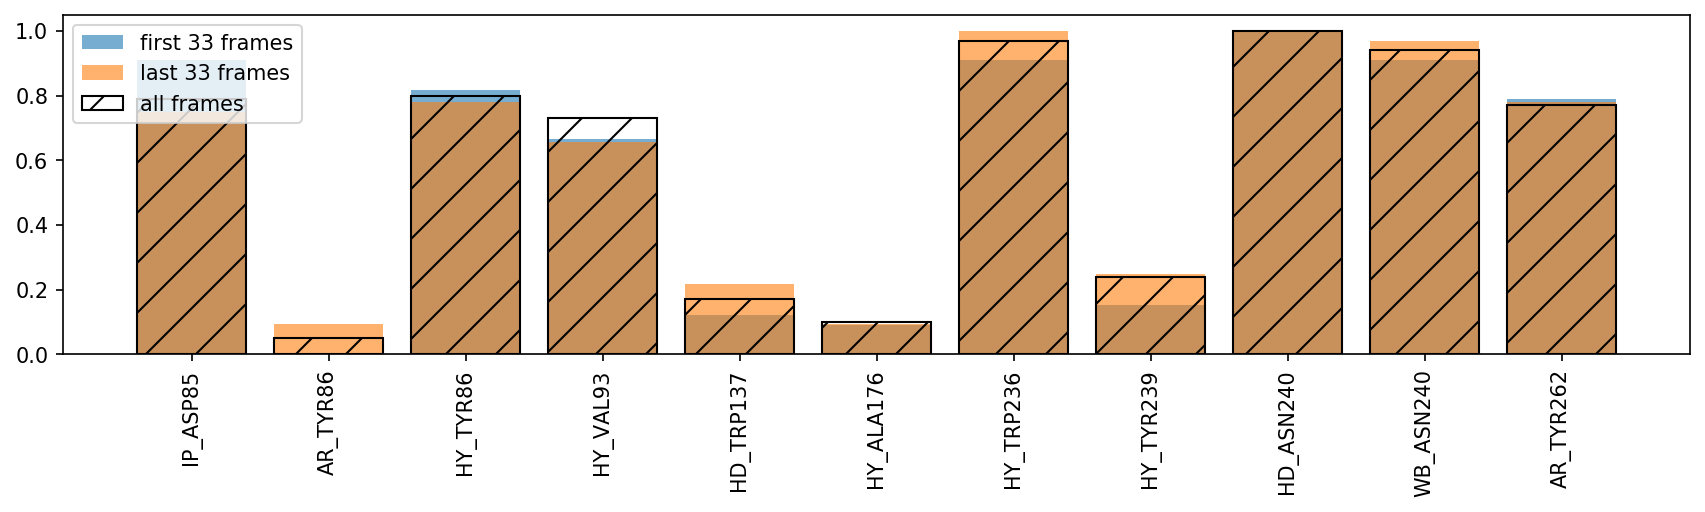

In [10]:
Plot_IF_trajectory(IFP_table,head_tail=-1)

### 2.3 Computation of PL IFPs for all dissociation trajectories (takes about 30 min) 

    (i) Only two RAMD trajectories will be analyzed (200 last frames)
        - relative residence time will be not computed because this would require least 10 RAMD trajectories (message "RAMD trajectory set for Replica1 is too small") 
        - only IFPs are computed (no unspecific contacts , i.e. "RE= False"), that is why only IFP plot and "Water shell" plot will be shown 

In [11]:
import MDAnalysis as mda
from Scripts.IFP_generation import *
from Scripts.Trajectories import *
from rdkit import Chem

# Define the path to the stored data
DIR_all = "Data/4MQT/"
DIR_ramd = "RAMD/Replica*"
DIR_namd = "NAMD_eq/Replica*"
ref_pdb =  "AMBER_eq/ORTO-CHL-prod8-NPT.pdb"
ligand_pdb = "IXO.pdb"
ligand_mol2 = "moe.mol2"
name  = "M2"

# Instantiate the trajectorie object with the paths/ filenames for the data
tr = trajectories(DIR_all,namd_tmpl= DIR_namd, ramd_tmpl= DIR_ramd, ligand_pdb=ligand_pdb,
                  ligand_mol2=ligand_mol2,ramd_traj_tmpl = "Traj*/*dcd",pdb = ref_pdb, timestep = 1)

Atoms found in the MOL2 file:  ['C01', 'N02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'O09', 'C10', 'N11', 'O12', 'C13', 'C14', 'H011', 'H012', 'H013', 'H031', 'H032', 'H033', 'H041', 'H042', 'H043', 'H051', 'H052', 'H081', 'H082', 'H131', 'H132', 'H141', 'H142']
...............Ligand properties:................
Acceptor ['O09', 'O12']
PosIonizable ['N02']
Hydrophobe ['C14', 'C06', 'C07']
............Important! ........
The following residue names will be used to identify ligand in the PDB file:  ['IXO']
Ligand atoms found in the trajectory  IXO
ligand name:       IXO
Equilibration trajectories will be searched using the template:  Data/4MQT//NAMD_eq/Replica*/*dcd
1  Equilibration trajectories found
Dissociation trajectories will be searched using the template:  Data/4MQT//RAMD/Replica*/Traj*/*dcd
2  RAMD traj. found in  Data/4MQT//RAMD\Replica1
2  RAMD traj. found in  Data/4MQT//RAMD\Replica2


!!!! RAMD trajectory set for Replica1 is too small (2 traj.), tau will not be computed for this replica 
!!!! RAMD trajectory set for Replica2 is too small (2 traj.), tau will not be computed for this replica 


>>>>>>>>>>>>>>>>> Replica  0 :  Replica1 

>>>>>>>>>= 0 Data/4MQT//RAMD\Replica1\Traj1\ORTO-CHL_108_ramd_016.dcd
total number of frames= 721; file size 983 M
>>>sub-system selected   protein or (resname HOH WAT SOL)  or (resname  IXO)
will be analyzed  50 frames
traj# 0 RMSD protein:  1.7944282519744854 RMSD ligand:  1.5528813967099457 ligand residue name IXO
for the frame 42 ligand RMSD is very large: 10.060345408600618
for the frame 43 ligand RMSD is very large: 11.29884853884316
for the frame 44 ligand RMSD is very large: 11.082218769004662
for the frame 45 ligand RMSD is very large: 11.989889151411315
for the frame 46 ligand RMSD is very large: 13.664263392288248
for the frame 47 ligand RMSD is very large: 15.244168342244368
for the frame 48 ligand RMSD is very large: 19.35

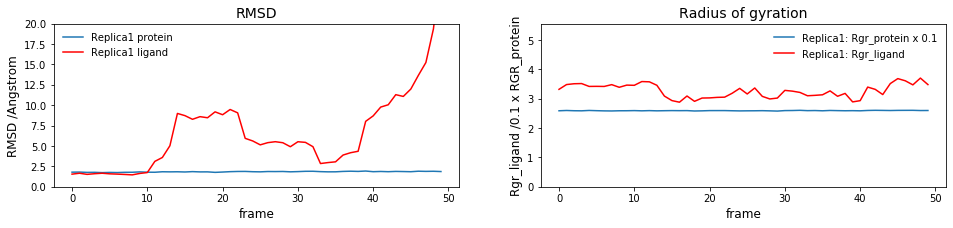

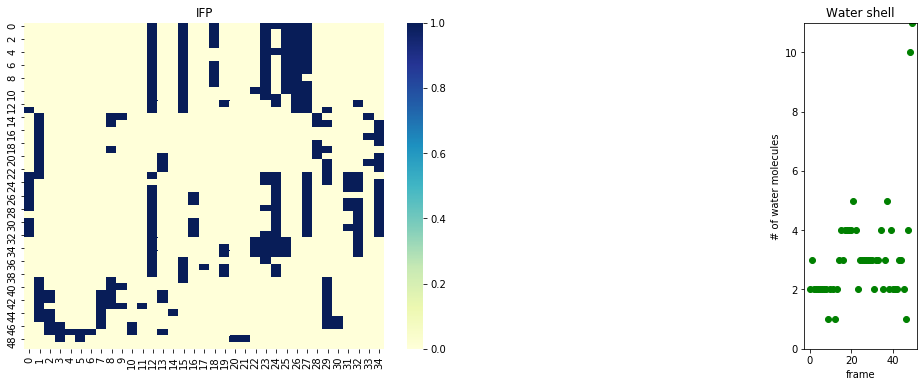

>>>>>>>>>= 1 Data/4MQT//RAMD\Replica1\Traj2\ORTO-CHL_104_ramd_016.dcd
total number of frames= 452; file size 616 M
>>>sub-system selected   protein or (resname HOH WAT SOL)  or (resname  IXO)
will be analyzed  50 frames
traj# 0 RMSD protein:  1.7455431202017444 RMSD ligand:  1.446788182764909 ligand residue name IXO
for the frame 44 ligand RMSD is very large: 10.504850361395674
for the frame 45 ligand RMSD is very large: 11.153463897281531
for the frame 46 ligand RMSD is very large: 11.285078970300532
for the frame 47 ligand RMSD is very large: 14.6125950120132
for the frame 48 ligand RMSD is very large: 19.2708384756754
for the frame 49 ligand RMSD is very large: 27.7203055930756
Start HB analysis 17:56:26.545659
Start WB analysis 17:56:34.526074
Start collecting IFPs:  17:57:29.196670
Start building IFP table:  18:02:25.034544
IFP database is ready  18:02:25.061526


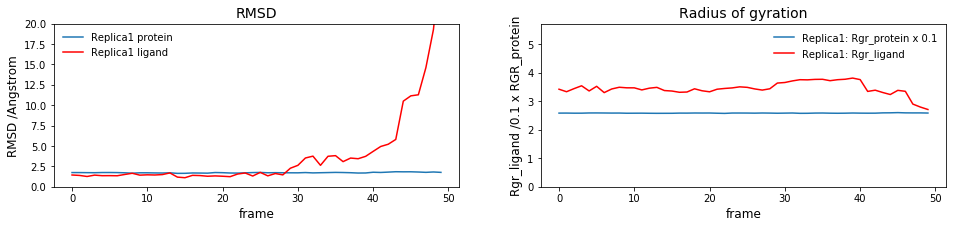

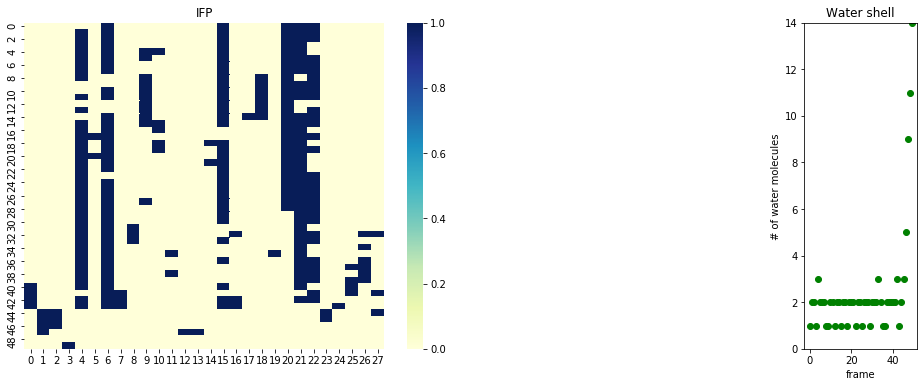



>>>>>>>>>>>>>>>>> Replica  1 :  Replica2 

>>>>>>>>>= 0 Data/4MQT//RAMD\Replica2\Traj1\ORTO-CHL_111_ramd_016.dcd
total number of frames= 144; file size 196 M
>>>sub-system selected   protein or (resname HOH WAT SOL)  or (resname  IXO)
will be analyzed  50 frames
traj# 0 RMSD protein:  1.980573157048027 RMSD ligand:  1.3151278859753737 ligand residue name IXO
for the frame 48 ligand RMSD is very large: 15.562495239382967
for the frame 49 ligand RMSD is very large: 23.35323142486338
Start HB analysis 18:04:23.809817
Start WB analysis 18:04:30.902745
Start collecting IFPs:  18:05:23.155723
Start building IFP table:  18:10:09.077454
IFP database is ready  18:10:09.092444


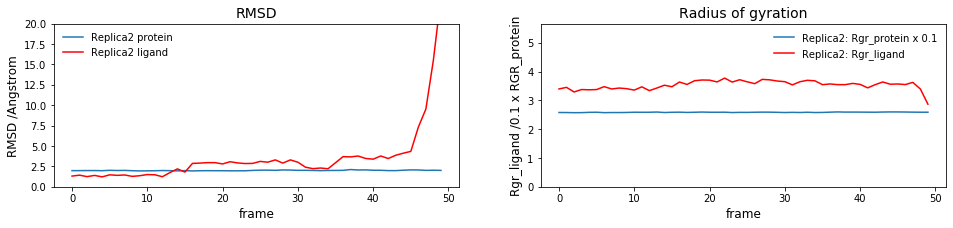

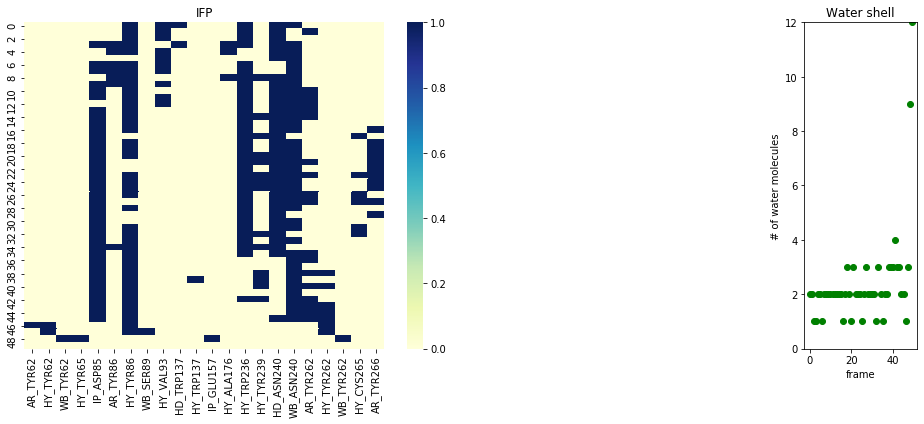

>>>>>>>>>= 1 Data/4MQT//RAMD\Replica2\Traj2\ORTO-CHL_105_ramd_016.dcd
total number of frames= 405; file size 552 M
>>>sub-system selected   protein or (resname HOH WAT SOL)  or (resname  IXO)
will be analyzed  50 frames
traj# 0 RMSD protein:  1.8441344602082994 RMSD ligand:  1.5553976154512552 ligand residue name IXO
for the frame 25 ligand RMSD is very large: 10.866057163141951
for the frame 26 ligand RMSD is very large: 12.089188053984627
for the frame 27 ligand RMSD is very large: 14.047216349166417
for the frame 28 ligand RMSD is very large: 15.100338030102748
for the frame 29 ligand RMSD is very large: 15.289352515381978
for the frame 30 ligand RMSD is very large: 15.43331081969671
for the frame 31 ligand RMSD is very large: 15.302516647481482
for the frame 32 ligand RMSD is very large: 15.400237057347208
for the frame 33 ligand RMSD is very large: 15.465616885092096
for the frame 34 ligand RMSD is very large: 15.93864083783456
for the frame 35 ligand RMSD is very large: 15.847314

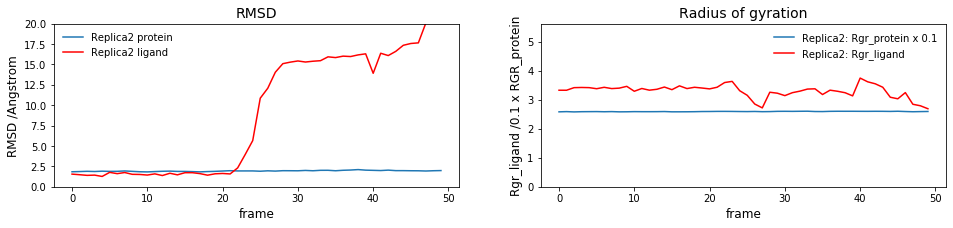

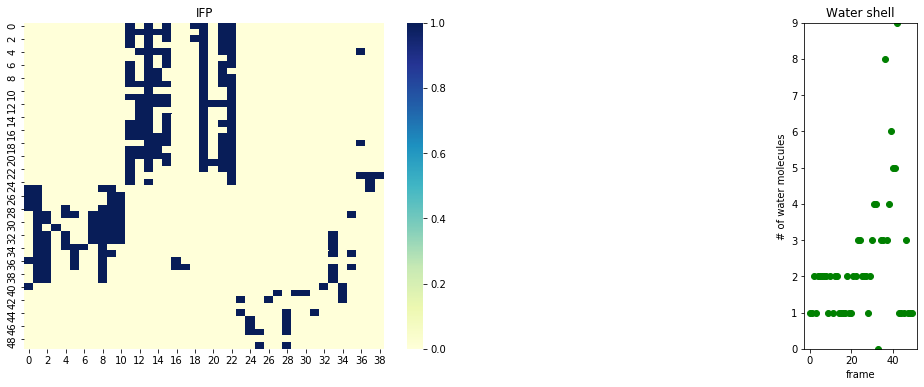

++++Will be saved +++++ ['Replica1', 'Replica2']


time  AR_TYR62  HY_TYR62  AR_TYR65  HY_TYR65  AR_TRP71  HY_TRP71  \
0      0         0         0         0         0         0         0   
1      1         0         0         0         0         0         0   
2      2         0         0         0         0         0         0   
3      3         0         0         0         0         0         0   
4      4         0         0         0         0         0         0   
..   ...       ...       ...       ...       ...       ...       ...   
45    45         0         0         0         0         0         0   
46    46         0         0         0         0         0         0   
47    47         0         0         0         0         0         0   
48    48         0         0         0         0         0         0   
49    49         0         0         0         0         0         0   

    HD_TRP81  HY_TRP81  AR_TRP81  ...  WB_TYR62  WB_TYR65  WAT      Repl  \
0          0         0         0  ...         0         0    2  Replica1   
1          0         0         0  ...         0         0    3  Replica1   
2          0         0         0  ...         0         0    2  Replica1   
3          0         0         0  ...         0         0    2  Replica1   
4          0         0         0  ...         0         0    2  Replica1   
..       ...       ...       ...  ...       ...       ...  ...       ...   
45         0         0         0  ...         0         0    1  Replica2   
46         0         0         0  ...         0         0    3  Replica2   
47         0         0         0  ...         0         0    1  Replica2   
48         0         0         0  ...         0         0    1  Replica2   
49         0         0         0  ...         0         0    1  Replica2   

    Traj      RMSDl     RMSDp      RGyr  length                    COM  
0      0   1.552881  1.794428  3.320584     721   [46.6, 47.04, 59.46]  
1      0   1.662644  1.805608  3.483078     721  [46.69, 46.54, 59.33]  
2      0   1.523883  1.767747  3.510939     721  [46.66, 46.82, 59.45]  
3      0   1.605563  1.775628  3.517285     721   [46.7, 46.66, 59.28]  
4      0   1.663392  1.737660  3.419742     721  [46.76, 46.83, 59.13]  
..   ...        ...       ...       ...     ...                    ...  
45     1  17.575248  1.969224  3.031356     405  [60.43, 45.01, 48.97]  
46     1  17.652291  1.964150  3.244653     405  [61.05, 45.15, 49.58]  
47     1  20.099481  1.936687  2.843083     405   [63.36, 45.32, 48.5]  
48     1  21.420858  1.970441  2.791120     405  [64.69, 45.55, 48.09]  
49     1  22.151493  1.990036  2.688825     405  [64.83, 45.61, 46.99]  

[200 rows x 73 columns]

In [12]:
# Read the RAMD trajectories
tr.ramd.scan_ramd()

tr.sub_system = " protein or (resname HOH WAT SOL) "
# Compute the IFPs for the RAMD dissociation trajectories
tr.analysis_all_ramd(WB_analysis = True, RE= False, step_analysis=2, start_analysis=-100)

# Safe the IFP dataframe to the specified location
tr.ramd.IFP_save(tr.PRJ_DIR+name+"_RAMD_com.pkl")

### 2.4 Loading back the generated IFP table and plotting results

    The generated and saved in the previous step IFP table can be then loaded from the  file and analyzed

In [13]:
IFP_data = pd.read_pickle(tr.PRJ_DIR+name+"_RAMD_com.pkl")


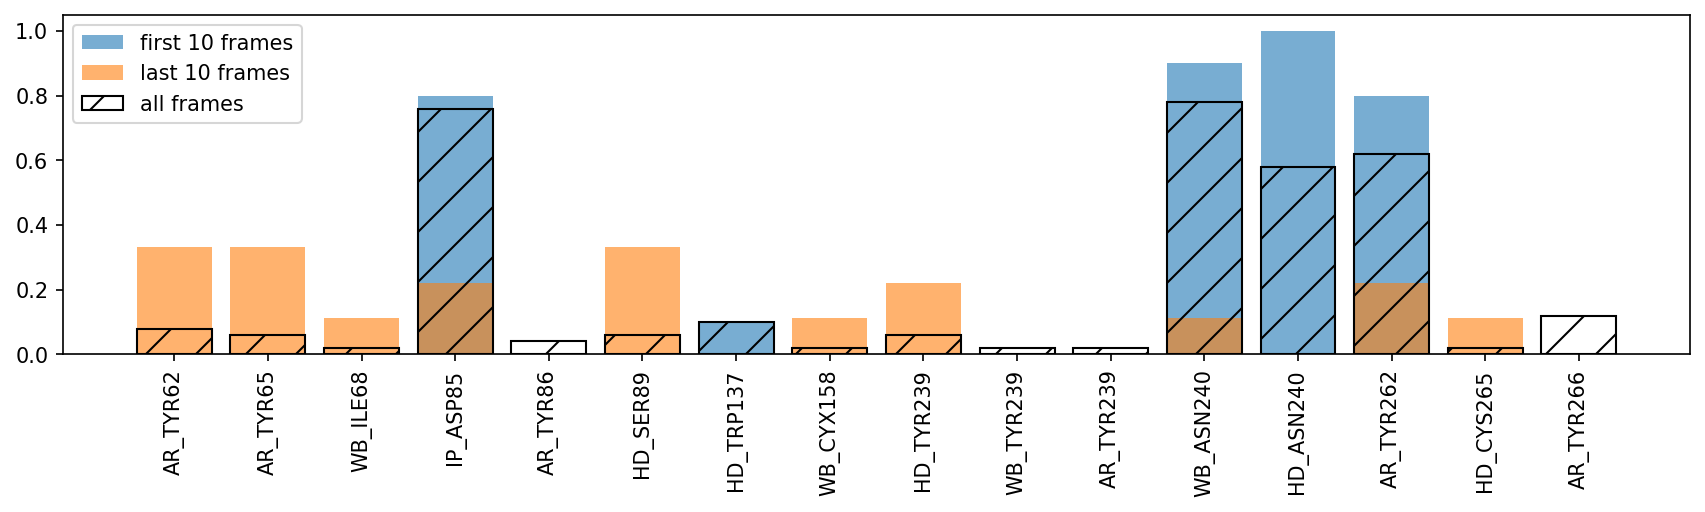

In [14]:
IFP_data_Repl1 = IFP_data[((IFP_data.Repl == "Replica1") )]
Plot_IF_trajectory(IFP_data_Repl1[(IFP_data_Repl1.Traj == "1")],ifp_type = np.asarray(['AR','HA','HD','IP','IN',"IO","WB"]),head_tail=10)

In [15]:
np.unique(IFP_data.length.values.astype(int))

array([144, 405, 452, 721])

In [16]:
tr.ramd. repl_traj
#                repl_traj = []
#                repl_names = [] 
#                length = []


[['Data/4MQT//RAMD\\Replica1\\Traj1\\ORTO-CHL_108_ramd_016.dcd',
  'Data/4MQT//RAMD\\Replica1\\Traj2\\ORTO-CHL_104_ramd_016.dcd'],
 ['Data/4MQT//RAMD\\Replica2\\Traj1\\ORTO-CHL_111_ramd_016.dcd',
  'Data/4MQT//RAMD\\Replica2\\Traj2\\ORTO-CHL_105_ramd_016.dcd']]

 one can see, that unlike equilibration trajectory, in dissociation trajectories contact in first 10 and last 10 frames are different